## MAL API Setup

In [1]:
import requests

api_url = 'https://api.myanimelist.net/v2'

# A Client ID is needed (https://myanimelist.net/apiconfig)
with open('client_id.txt', 'r') as f:
    CLIENT_ID = f.read()

headers = {'X-MAL-CLIENT-ID': CLIENT_ID}

def get_data(endpoint, params=None):
    url = api_url + endpoint
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

## Scrap Anime

In [9]:
import json
import os

scraping_save_pages = 'data/data_tmp/anime_pages'

if not os.path.exists(scraping_save_pages): # Create saving directory if it doesn't exist
  os.makedirs(scraping_save_pages)

endpoint = f'/anime/ranking'
limit = 500

anime_keys = ['id', 'title', 'main_picture', 'alternative_titles', 'start_date', 'end_date', 'synopsis', 'mean', 'rank', 'popularity',
              'num_list_users', 'num_scoring_users', 'num_favorites', 'nsfw', 'genres', 'created_at', 'updated_at', 'media_type', 'status',
              'num_episodes', 'start_season', 'broadcast', 'source', 'average_episode_duration', 'rating', 'studios']

def scrape_page(page):
    params = {'ranking_type': 'bypopularity', 'limit': limit, 'offset': page*limit, 'fields': ','.join(anime_keys)}
    data = get_data(endpoint, params)
    useful = [anime['node'] for anime in data['data']]
    with open(scraping_save_pages + f'/page{str(page).zfill(2)}.json', 'w') as f:
        json.dump(useful, f, indent=4)

In [12]:
import math

# 3 July 2022
previous_total_anime = 20_602
previous_last_page = math.ceil(previous_total_anime / limit) - 1

data = get_data(endpoint, {'ranking_type': 'bypopularity', 'limit': limit, 'offset': previous_last_page*limit, 'fields': ','.join(anime_keys)})
assert len(data['data']) > 0
assert 'next' not in data['paging']

last_page = previous_last_page

last_page

41

In [4]:
import tqdm
import time

for page in tqdm.trange(last_page+1):
    scrape_page(page)
    time.sleep(1)

100%|██████████| 42/42 [02:48<00:00,  4.02s/it]


## Merge Files

In [5]:
import os

scraping_save_pages = 'data/data_tmp/anime_pages'

data = []
for file_name in os.listdir(scraping_save_pages):
    file_path = os.path.join(scraping_save_pages, file_name)
    with open(file_path, 'r') as f:
        file = json.load(f)
    data.extend(file)

len(data)

20602

In [6]:
with open('data/data_tmp/anime_raw.json', 'w') as f:
    json.dump(data, f, indent=4)

## Anime Cleaning

In [1]:
import pandas as pd
import numpy as np
import json

with open('data/data_tmp/anime_raw.json', 'r') as f:
    data = json.load(f)

anime = pd.json_normalize(data, sep='_')

# They rank mean and num_list_users "wrong": draws sorted alphabetically (maybe even split at middle)
dropped_cols = ['rank', 'popularity']
#anime.drop(columns=dropped_cols, inplace=True)

# Use Timestamps
anime['start_date'] = pd.to_datetime(anime['start_date'])
anime['end_date'] = pd.to_datetime(anime['end_date'])

# Avoid false zeroes and unnecessary float
anime['num_episodes'] = anime['num_episodes'].replace(0, np.nan).astype('Int64')

# Use Timedelta
anime['average_episode_duration'] = pd.to_timedelta(anime['average_episode_duration'].replace(0, np.nan), unit='s')

# Avoid floats, as time
anime['start_season_year'] = anime['start_season_year'].astype('Int64')
anime['broadcast_start_time'] = pd.to_datetime(anime['broadcast_start_time']).dt.time

# Only keep names
anime['genres'] = anime['genres'].apply(lambda x: [dic['name'] for dic in x] if not x is np.nan else [])
anime['studios'] = anime['studios'].apply(lambda x: [dic['name'] for dic in x] if not x is np.nan else [])

# MyAnimeList edits
anime['created_at'] = pd.to_datetime(anime['created_at'])
anime['updated_at'] = pd.to_datetime(anime['updated_at'])

# Avoid empty string
anime['synopsis'] = anime['synopsis'].replace('', np.nan)
anime['alternative_titles_en'] = anime['alternative_titles_en'].replace('', np.nan)
anime['alternative_titles_ja'] = anime['alternative_titles_ja'].replace('', np.nan)
                      

order = ['id', 'title', 'media_type', 'mean', 'num_scoring_users',                          # 10 Most important attributes, 
         'status', 'num_episodes', 'start_date', 'end_date', 'source',                      # appearing first on kaggle

         'num_list_users', 'num_favorites', 'average_episode_duration', 'rating',           # Other important
         'start_season_year','start_season_season',                                         # attributes
         'broadcast_day_of_the_week', 'broadcast_start_time',   

         'genres', 'studios',  'rank',                                                             # Multivalued attributes
         'synopsis', 'nsfw', 'created_at', 'updated_at',                                    # Description, MyAnimeList edits
         
         'main_picture_medium', 'main_picture_large',                                       # Media data
         'alternative_titles_en', 'alternative_titles_ja', 'alternative_titles_synonyms']   # Other titles


anime = anime[order]

# Save to csv
anime.to_csv('data/anime.csv', index=False)

pd.options.display.max_columns = None
anime.head(1)

,id,title,media_type,mean,num_scoring_users,status,num_episodes,start_date,end_date,source,num_list_users,num_favorites,average_episode_duration,rating,start_season_year,start_season_season,broadcast_day_of_the_week,broadcast_start_time,genres,studios,rank,synopsis,nsfw,created_at,updated_at,main_picture_medium,main_picture_large,alternative_titles_en,alternative_titles_ja,alternative_titles_synonyms
0,16498,Shingeki no Kyojin,tv,8.53,2469488,finished_airing,25,2013-04-07,2013-09-29,manga,3452617,153103,0 days 00:24:00,r,2013,spring,sunday,01:58:00,"[Action, Drama, Gore, Military, Shounen, Survi...",[Wit Studio],103.0,"Centuries ago, mankind was slaughtered to near...",white,2012-12-05 12:03:21+00:00,2022-04-18 05:00:25+00:00,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Attack on Titan,進撃の巨人,"[AoT, SnK]"


In [292]:
anime.shape

(20602, 29)

## Load Anime

In [179]:
from ast import literal_eval
import pandas as pd

anime = pd.read_csv('data/anime.csv')

columns_dtype_datetime = ['start_date', 'end_date', 'created_at', 'updated_at']
for col in columns_dtype_datetime:
    anime[col] = pd.to_datetime(anime[col])

columns_dtype_Int64 = ['num_episodes', 'popularity', 'rank', 'start_season_year']
for col in columns_dtype_Int64:
    anime[col] = anime[col].astype('Int64')

columns_dtype_list = ['genres', 'studios', 'alternative_titles_synonyms']
for col in columns_dtype_list:
    anime[col] = anime[col].apply(literal_eval)

anime['broadcast_start_time'] = pd.to_datetime(anime['broadcast_start_time']).dt.time   # Time of day

anime['average_episode_duration'] = pd.to_timedelta(anime['average_episode_duration'])  # Duration

anime.head(1)

,id,title,media_type,mean,num_scoring_users,status,num_episodes,start_date,end_date,source,num_list_users,popularity,num_favorites,rank,average_episode_duration,rating,start_season_year,start_season_season,broadcast_day_of_the_week,broadcast_start_time,genres,studios,synopsis,nsfw,created_at,updated_at,main_picture_medium,main_picture_large,alternative_titles_en,alternative_titles_ja,alternative_titles_synonyms
0,16498,Shingeki no Kyojin,tv,8.53,2469488,finished_airing,25,2013-04-07,2013-09-29,manga,3452617,1,153103,103,0 days 00:24:00,r,2013,spring,sunday,01:58:00,"[Action, Drama, Gore, Military, Shounen, Survi...",[Wit Studio],"Centuries ago, mankind was slaughtered to near...",white,2012-12-05 12:03:21+00:00,2022-04-18 05:00:25+00:00,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Attack on Titan,進撃の巨人,"[AoT, SnK]"


- Yesterday, 11:15 AM a Yesterday,  1:49 PM     52176                   Yesterday, 9:46 PM a Todayyyyy, 5:23 AM (i.e. Today, 5 del matí)
- Yesterday, 11:32 AM a Yesterday, 12:32 PM     52282                   Yesterday, 7:43 PM a Yesterday, 9:46 PM
- Yesterday, 11:16 AM a Yesterday, 12:49 PM     52301                   Yesterday, 4:53 PM a Yesterday, 9:48 PM
- Yesterday, 11:28 AM a Yesterday,  2:54 PM     52159                   Yesterday, 6:54 PM a ????
- Yesterday,  2:55 PM a Yesterday, 10:30 PM     52195 (deleted????)     Aquest segon canvi vist a les 17, abans no apareixia (alongside l'addició de 2 extres?)

                                                51832                   Yesterday, 9:01 PM a Yesterday, 9:49 PM


12 i 21:30???

Hasn't updated anymore yet (i.e. I don't see the changes)

52325 updated and added at 2022-07-07T 15:53:49

Jikan API somehow updates to old data????!!!! Per tant, MAI o CASI MAI té les últimes dades...
Yesterday, 12 del migdia???

Fins i tot la llista normal de MyAnimeList (de Favorits) es podia paginar malament, veient-se un mateix en dues pàgines i perdent un altre

- Not Ranked & != Not Yet Aired <--> Hentai or Erotica
- Rating rx --> Hentai, but 11 Hentai's have rating r+
- Should I split normal anime and Hentai/Erotica?
- Erotica -> Boys Love en tots menys un

Jikan may retrieve actually data from 5 minutes! (in Userupdates with a miss, though it took a while to actually load it, the first request failed)

[None]

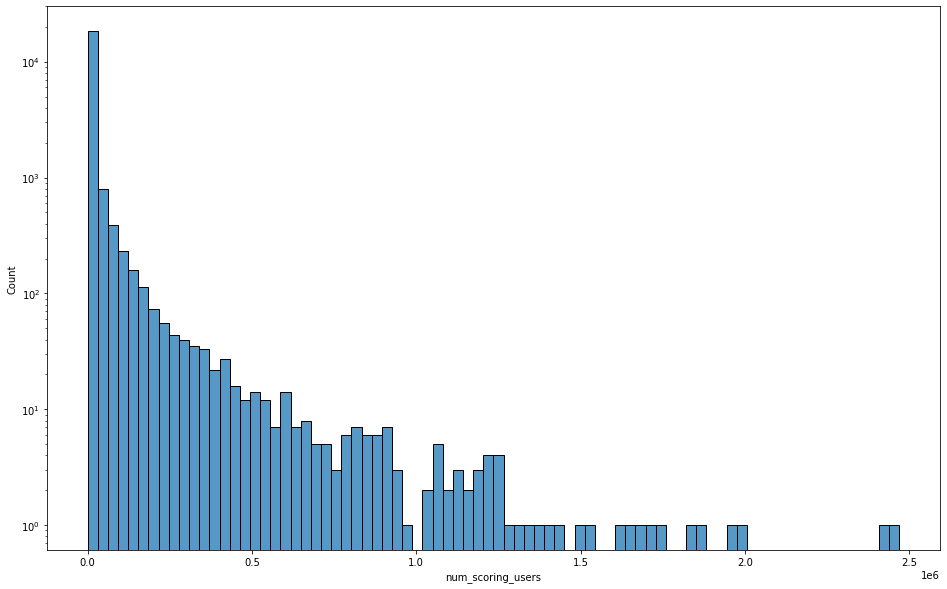

In [280]:
plt.figure(figsize=(16, 10))

splot = sns.histplot(anime, x='num_scoring_users', bins=80)
splot.set(yscale='log')

## Conclusió
- Algunes coses MAL les actualitza gairebé casi instant (últimes actualitzacions, PTW vs Watching vs CP) (en els de la temporada només??)
- Aparentment les notes donades i la mean 2 cops al dia
- Jikan té updates més estranyes, segons el que diu tot es fa caché de 24h, però quan agafa dades noves les agafa slightly velles?

### Ordenar meva llista (order)
0. Per defecte (status, alfabètic) -----
1. Títol
2. Data acabat
3. Data començat
4. Nota meva
5. Última modificació
6. Tipus
7. Per defecte (status, alfabètic) -----
8. Rating
9. Rewatch value...
10. Per defecte (status, alfabètic) -----
11. Prioritat
12. Episodis vistos
13. Storage
14. Air start date
15. Air end date
16. Status

### Ordre (o)

- w=1: ascendent (inverteix l'ordre)
- w=2: descendent (per defecte)
- no exactament així però algun w=0, 1 o 2 inverteix l'ordre

0. Alfabètic descendent
1. Alfabètic ascendent
2. Start date descendent
3. Nota descendent
4. Episodis descendent
5. End date descendent
6. Tipus (music, ...)
7. Membres descendent
8. Rating (rx, ...)
9. Id descendent (= data creació)

Els estats dins d'un anime s'actualitzen sovint (nº en cada estat i.e. Summary Stats) (vist 43470).
Els que no en tenen però (s'ha afegit fa poc) sembla que no

### Rank
-      1 a 12.749: per nota de 9.16 a 1.84
- 12.750 a 15.973: 'Mahou no S' a 'Zumono' (canvia el tall)
- 15.974 a 18.699: '"Aes' a 'Mahou no R'
- 18.700 a 20.602: resta descendent en membres (ve de com l'he descarregat...)

- Scored <--> 100+ (101?) notes vàlides (20%+ vist, excloent bots i voting memes)
- Ranked <--> No Hentai or Erotica i No not_yet_aired

Score no té més precicisó que 2 decimals, en cas d'empats s'ordena alfabèticament, tot i que a vegades es talla per una lletra random (ma)

### Rank

(7 July 2022)

- 1 a 12.781: per nota de 9.15 a 1.84 (els que tenen mateixa nota està ordenat alfabètic o weird alfabètic)

Aired, alfabètic amb un tall (canvia) (tenen rank encara, but really stupid)
- 12.782 a 16.064: 'Magic Adventures'   a 'Zumono'
- 16.065 a 18.821: '"Aes'               a 'Magic'

Not aired, alfabètic amb un tall (sense rank)
- 18.822 a 19.052: 'Mahou Shoujo'       a 'Zuoshou'
- 19.053 a 19.252: '"Oshi no'           a 'Made in Abyss'

Tots els Rx - Hentai
- 19.253 a 20.702: 'Kaede to Suzu'      a 'Tsui no Sora' (ordenats per nota)
- 20.703 a 20.725: 'Mori no Kuma-san'   a 'Korogashi Ryouta' (alfabètic amb tall)

Conclusió: rank és kinda stupid, només s'utilitzen els decimals de score i es separa el Hentai

### Popularity
També es fan els desempats alfabèticament man

- 39449, 40089, 28361, 10244 spammed (new accounts, duplicate accounts)
- 48391, 11541 not even finished